<a href="https://colab.research.google.com/github/SeunghyeChae/CAKD3_tmdhey/blob/main/13.%20%EB%94%A5%EB%9F%AC%EB%8B%9D/dl_introduction_to_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://lifeignite.tistory.com/53


GAN 구조는 다음과 같습니다.
1. Generator 네트워크는 (latent_dim,) 크기의 벡터를 (32,32,3) 크기의 이미지로 매핑합ㄴ디ㅏ.
2. discriminator 네트워크는 (32,32,3)크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑합니다.
3. 생성자와 판별자를 연결하는 gan 네트워크를 만듭니다.
gan(x) = discriminator(generator(x))입니다. 이 gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑합니다. 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가합니다.
4. '진짜'/'가짜' 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련합니다. 일반적인 이미지 분류 모델을 훈련하는 것과 동일합니다.
5. 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용합니다. 이 말은 매 단계 마다 생성자에 의해 디코딩된 이미지를 판별자가 '진짜'로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻입니다. 다른 말로 하면 판별자를 속이도록 생성자를 훈련합니다.

In [5]:
# 생성자
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
# 입력을 16*16 zmrldml 128개 채널을 가진 큭성 맵으로 변환
x = layers.Dense(128*16*16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x)

# 합성곱 층을 추가
x = layers.Conv2D(265, 5, padding='same')(x) # same 인풋 아웃풋 같음

# 32*32크기의 업샘플링
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 추가
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32*32 크기의 1개 채널을 가진 특성 맵을 생성
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 265)       848265    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      1085696   
 nspose)                                                         
                                                             

In [7]:
# 판별자 

discriminator_input= layers.Input(shape=(height,width,channels))
x= layers.Conv2D(128,3)(discriminator_input)
x= layers.LeakyReLU()(x)
x= layers.Conv2D(128,4,strides=2)(x)
x= layers.LeakyReLU()(x)
x= layers.Conv2D(128,4,strides=2)(x)
x= layers.LeakyReLU()(x)
x= layers.Conv2D(128,4,strides=2)(x)
x= layers.Flatten()(x)

x= layers.Dropout(0.4)(x)

x= layers.Dense(1,activation='sigmoid')(x)

discriminator= keras.models.Model(discriminator_input,x)
discriminator.summary()

discriminator_optimizer= keras.optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss= 'binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6, 6, 128)         0   

In [10]:
# 판별자의 가중치가 훈련되지 않도록 설정

discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output= discriminator(generator(gan_input))
gan= keras.models.Model(gan_input,gan_output)

gan_optimizer= keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')



In [11]:
import os 
from tensorflow.keras.preprocessing import image
(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 5s 0us/step


In [13]:
x_train.shape

(50000, 32, 32, 3)

In [19]:
import pandas as pd 
pd.DataFrame(y_train).value_counts()

9    5000
8    5000
7    5000
6    5000
5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
dtype: int64

In [20]:
x_train = x_train [y_train.flatten()==6]

In [22]:
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32')/255.

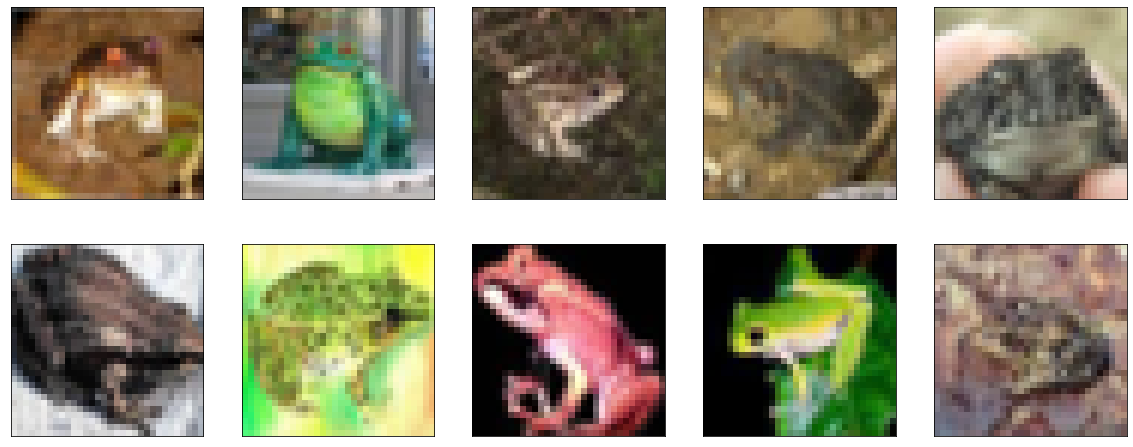

In [23]:
import matplotlib.pyplot as plt 
plt.figure(figsize =(20,8))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
plt.show()
plt.close()

In [24]:
os.mkdir('./datasets')

In [25]:
iterations= 10000
batch_size = 20
save_dir = './datasets/gan_images/'

In [33]:
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

start=0
for step in range(iterations):
  # 잠재공간에 무작위로 포인트 샘플링
  random_latent_vactors= np.random.normal(size=(batch_size,latent_dim))

  # 가짜 이미지를 디코딩
  generated_images = generator.predict(random_latent_vactors)

  # 진짜 이미지와 연결 
  stop =  start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])

  labels= np.concatenate([np.ones((batch_size,1)),
                          np.zeros((batch_size,1))])
  
  # 레이블에 랜덤 노이즈를 추가
  labels += 0.05 * np.random.random(labels.shape)

  # discriminator 훈련
  d_loss = discriminator.train_on_batch(combined_images,labels)

  # 잠재 공간에서 무작위로 포인트 샘플링 
  random_latent_vactors = np.random.normal(size=(batch_size,latent_dim))

  # 모두 진짜 이미지라고 레이블을 만듦
  misleading_target = np.zeros((batch_size,1))


  # generator 훈련
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_target)


  start += batch_size
  if start > len(x_train) - batch_size :
    start= 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print('스탭 %s에서 판별자 손실: %s' %(step,d_loss))
    print('스탭 %s에서 적대적 손실: %s' %(step,a_loss))

    # 생성된 이미지 하나를 저장
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir,'generated_frog' + str(step) + '.png'))

    # 비교를 위하여 진짜 이미지 하나를 저장
    img = image.array_to_img(real_images[0]* 255., scale=False)
    img.save(os.path.join(save_dir,'real_frog'+str(step)+'.png'))

스탭 0에서 판별자 손실: -0.02922261878848076
스탭 0에서 적대적 손실: 12.081812858581543
스탭 100에서 판별자 손실: 0.7674462199211121
스탭 100에서 적대적 손실: 1.0584051609039307
스탭 200에서 판별자 손실: 0.7170622944831848
스탭 200에서 적대적 손실: 0.6640347242355347
스탭 300에서 판별자 손실: 0.5644233226776123
스탭 300에서 적대적 손실: 0.698196291923523
스탭 400에서 판별자 손실: 0.7343424558639526
스탭 400에서 적대적 손실: 0.6770845651626587
스탭 500에서 판별자 손실: 0.6165064573287964
스탭 500에서 적대적 손실: 0.5369640588760376
스탭 600에서 판별자 손실: 0.6892293691635132
스탭 600에서 적대적 손실: 0.632011353969574
스탭 700에서 판별자 손실: 0.7129278182983398
스탭 700에서 적대적 손실: 0.8727880716323853
스탭 800에서 판별자 손실: 0.712752640247345
스탭 800에서 적대적 손실: 0.5288118720054626
스탭 900에서 판별자 손실: 0.6984847784042358
스탭 900에서 적대적 손실: 0.7199575304985046
스탭 1000에서 판별자 손실: 0.5668796300888062
스탭 1000에서 적대적 손실: 0.3390354514122009
스탭 1100에서 판별자 손실: 0.7549452781677246
스탭 1100에서 적대적 손실: 0.8453911542892456
스탭 1200에서 판별자 손실: 0.6493215560913086
스탭 1200에서 적대적 손실: 0.46319469809532166
스탭 1300에서 판별자 손실: 0.6623493432998657
스탭 1300에서 적대적 손실: 0.34468

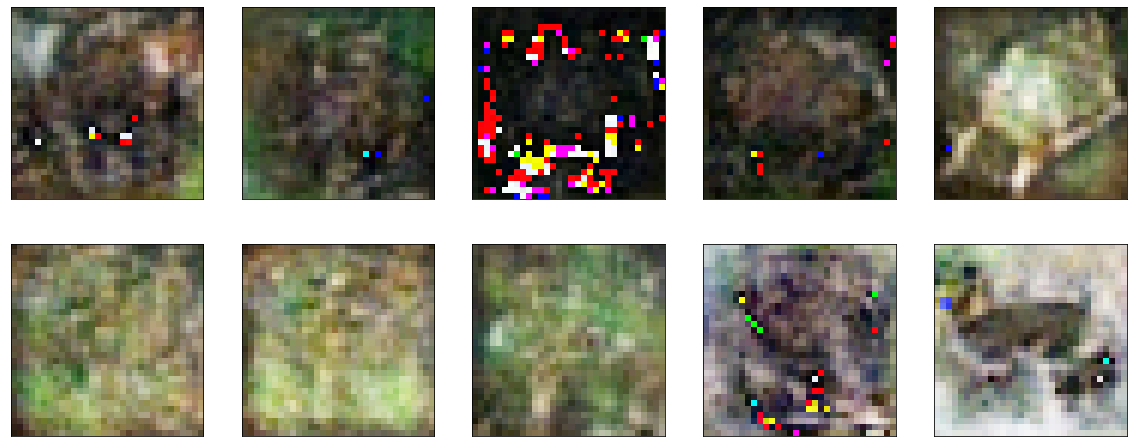

In [34]:
# 가짜 이미지 몇 개를 출력 
random_latent_vectors = np.random.normal(size=(10,latent_dim))
generated_images = generator.predict(random_latent_vectors)
plt.figure(figsize=(20,8))
for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  img= image.array_to_img(generated_images[i] * 255., scale=False)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
plt.show()
plt.close()